**from ewa_data_008.04_learn_pi_data**

- fit idobs with and without Beta

In [1]:
import os
import pickle

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pystan
import seaborn as sns

import sys
print(sys.version)

3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0]


# Stan Data

In [2]:
path_ds = os.path.join('/media','thiagoatserver','Neurodata','Datasets','matching_fix')

In [3]:
fname_pickle = os.path.join(path_ds,'df_big.pickle')

if os.path.isfile(fname_pickle):
    with open(fname_pickle,'rb') as fhandle:
        df_big = pickle.load(fhandle)

In [4]:
ndx = ['isChoiceLeft', 'isRewarded',
       'idobs_pLeft', 'idobs_pRight', 'subj', 'sess']
df = df_big.loc[(df_big.isChoiceLeft | df_big.isChoiceRight),ndx]
df.loc[:,['isChoiceLeft', 'isRewarded']]=df.loc[:,['isChoiceLeft', 'isRewarded']].astype(int)

df_dummy = pd.get_dummies(df.loc[:,'subj'])

sns.heatmap(df_dummy)

In [5]:
df_stan = df.copy()#.iloc[10000:12000,:].copy()
dict_subj = {i+1:n for i,n in enumerate(df_stan.subj.drop_duplicates().sort_values())}
for isubj,subj in dict_subj.items():
    df_stan.loc[df_stan.subj==subj,'subj']=isubj

dict_subj

{1: 'TG016',
 2: 'TG017',
 3: 'TG018',
 4: 'TG021',
 5: 'TG023',
 6: 'TG024',
 7: 'TG025',
 8: 'TG026'}

In [6]:
dict_sess = {i+1:n for i,n in enumerate(df_stan.sess.drop_duplicates().sort_values())}
for isess,sess in dict_sess.items():
    df_stan.loc[df_stan.sess==sess,'sess']=isess

# dict_sess

In [7]:
stan_data = df_stan.to_dict(orient='list')

In [8]:
stan_data['N'] = df_stan.shape[0]
stan_data['L'] = len(dict_subj)
stan_data['S'] = len(dict_sess)

# Stan Code

In [9]:
stan_data.keys()

dict_keys(['isChoiceLeft', 'isRewarded', 'idobs_pLeft', 'idobs_pRight', 'subj', 'sess', 'N', 'L', 'S'])

decision completely controlled by learn_pi estimate of reward probability

## stan_code_idobs

### without Beta

In [30]:
stan_code_e = """data {
  int<lower=0> N;
  int<lower=1> L;
  int<lower=1> S;
  int<lower=0,upper=1> isChoiceLeft[N];
  int<lower=0,upper=1> isRewarded[N];
  int<lower=1,upper=L> subj[N];
  int<lower=1,upper=S> sess[N];
}
parameters {
  real<lower=0,upper=1> eta[L];
}
transformed parameters {

}
model {
  vector[N] Ql_e;
  vector[N] Qr_e;
  int kL = 1;
  int kR = 1;
  int flag = 1;
  real piL;
  real piR;
  real temp;
  for (l in 1:L){
    eta[l] ~ beta(0,0.1);    
  }
  for (n in 1:N){
    if (n == 1 || subj[n] != subj[n-1] || sess[n] != sess[n-1]){
      piL = 0;
      piR = 0;
      kL = 1;
      kR = 1;
      flag = 1;
    }
    if (flag == 1){
      Ql_e[n] = 1-(1+exp(piL))^(-kL);
      Qr_e[n] = 1-(1+exp(piR))^(-kR);
      if (isChoiceLeft[n]){
        temp = kL*exp(piL)/(1+exp(piL))*((isRewarded[n]/(1-(1+exp(piL))^kL)) + (1-isRewarded[n]));
        if (is_nan(temp)){
          print(n, " kL:", kL, " piL:", piL, " eta:", eta[subj[n]])
          flag = 0;
        }
        piL = piL - eta[subj[n]]*temp;
        kL = 1;
        kR += 1;
      }
      else {
        temp = kR*exp(piR)/(1+exp(piR))*(isRewarded[n]*(1/(1-(1+exp(piR))^kR)) + (1-isRewarded[n]));
        if (is_nan(temp)){
          print(n, " kR:", kR, " piR:", piR, " eta:", eta[subj[n]])
          flag = 0;
        }
        piR = piR  - eta[subj[n]]*temp;
        kL += 1;
        kR = 1;
      }
    }  
  }
  isChoiceLeft ~ bernoulli_logit((Ql_e-Qr_e));
}
"""
sm_e2 = pystan.StanModel(model_code=stan_code_e)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_041eb2faaeb4c88f70039afb00f6384c NOW.
/home/thiago/Programs/anaconda2/envs/ml2/lib/python3.6/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpd2wmtve8/stanfit4anon_model_041eb2faaeb4c88f70039afb00f6384c_4658996438153601580.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [31]:
fit_e2 = sm_e2.sampling(data=stan_data, iter=100, chains=6,verbose=True)

fit_e2

Inference for Stan model: anon_model_041eb2faaeb4c88f70039afb00f6384c.
6 chains, each with iter=100; warmup=50; thin=1; 
post-warmup draws per chain=50, total post-warmup draws=300.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
eta[1]   0.99  3.6e-4 8.4e-3   0.97   0.99   0.99    1.0    1.0    533    1.0
eta[2]   0.99  3.0e-4 6.8e-3   0.97   0.99   0.99    1.0    1.0    511   0.99
eta[3]   0.98  8.8e-4   0.02   0.93   0.97   0.99   0.99    1.0    396    1.0
eta[4]   0.99  3.7e-4 7.4e-3   0.97   0.99   0.99    1.0    1.0    394   0.99
eta[5]   0.96  1.4e-3   0.03   0.89   0.95   0.97   0.99    1.0    469    1.0
eta[6]   0.15  1.5e-3   0.03    0.1   0.12   0.14   0.16   0.22    447   0.99
eta[7]   0.99  7.6e-4   0.01   0.95   0.98   0.99    1.0    1.0    294   1.01
eta[8]   0.99  2.7e-4 5.8e-3   0.98   0.99    1.0    1.0    1.0    452   0.99
lp__   -2.3e4    0.31   2.21 -2.3e4 -2.3e4 -2.3e4 -2.3e4 -2.3e4     51   1.12

Samples were drawn using NUTS at Wed

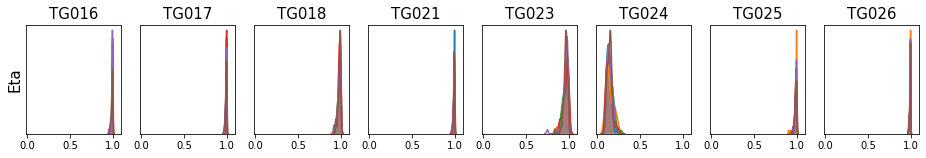

In [33]:
myvars = np.array(fit_e2.flatnames)[[n.startswith('e') for n in fit_e2.flatnames]]
df_diag_e = fit_e2.to_dataframe()
fs = 15
hf, ha = plt.subplots(1,len(dict_subj),figsize=(2*len(dict_subj),2),sharex=True)

for i, var in enumerate(myvars):
    for j, chain in enumerate(np.unique(df_diag_e.chain)):
        sns.kdeplot(df_diag_e.loc[df_diag_e.chain==chain,var], ax=ha[i],shade=True,legend=False)
        if i==0 and j== 0:
            ha[i].set_ylabel('Eta',fontsize=fs)
        if j==0:
            ha[i].set_yticks([])
            ha[i].set_title(dict_subj[i+1],fontsize=fs)
#             ha[i].text(0.1,.9,dict_subj[i+1],transform=ha[i].transAxes)

# myvars = np.array(fit_e.flatnames)[[n.startswith('b') for n in fit_e.flatnames]]
# for i, var in enumerate(myvars):
#     for j, chain in enumerate(np.unique(df_diag_e.chain)):
#         sns.kdeplot(df_diag_e.loc[df_diag_e.chain==chain,var], ax=ha[1,i],shade=True,legend=False)
#         if i==0 and j== 0:
#             ha[1,i].set_ylabel('Beta',fontsize=fs)     

In [ ]:
myvars = np.array(fit_e.flatnames)[[n.startswith('e') for n in fit_e.flatnames]]
df_diag_e = fit_e.to_dataframe()
fs = 15
hf, ha = plt.subplots(1,len(dict_subj),figsize=(2*len(dict_subj),2),sharex=False)

for i, var in enumerate(myvars):
    for j, chain in enumerate(np.unique(df_diag_e.chain)):
        sns.kdeplot(df_diag_e.loc[df_diag_e.chain==chain,var], ax=ha[i],shade=True,legend=False)
        if i==0 and j== 0:
            ha[i].set_ylabel('Eta',fontsize=fs)
        if j==0:
            ha[i].set_yticks([])
            ha[i].set_title(dict_subj[i+1],fontsize=fs)
#             ha[i].text(0.1,.9,dict_subj[i+1],transform=ha[i].transAxes)

# myvars = np.array(fit_e.flatnames)[[n.startswith('b') for n in fit_e.flatnames]]
# for i, var in enumerate(myvars):
#     for j, chain in enumerate(np.unique(df_diag_e.chain)):
#         sns.kdeplot(df_diag_e.loc[df_diag_e.chain==chain,var], ax=ha[1,i],shade=True,legend=False)
#         if i==0 and j== 0:
#             ha[1,i].set_ylabel('Beta',fontsize=fs)     

### with Beta

In [ ]:
stan_code_idobs = """data {
  int<lower=0> N;
  int<lower=1> L;
  int<lower=1> S;
  int<lower=0,upper=1> isChoiceLeft[N];
  int<lower=0,upper=1> isRewarded[N];
  int<lower=1,upper=L> subj[N];
  int<lower=1,upper=S> sess[N];
}
parameters {
  real<lower=0,upper=1> eta[L];
  vector<lower=0,upper=100>[L] beta;
}
transformed parameters {

}
model {
  vector[N] Ql_idobs;
  vector[N] Qr_idobs;
  int kL = 1;
  int kR = 1;
  real piL;
  real piR;
  real temp;
  beta ~ cauchy(0,3);
  for (l in 1:L){
    eta[l] ~ uniform(0,1);    
  }
  for (n in 1:N){
    if (n == 1 || subj[n] != subj[n-1] || sess[n] != sess[n-1]){
      piL = 0;
      piR = 0;
      kL = 1;
      kR = 1;
    }
    Ql_idobs[n] = 1-(1+exp(piL))^(-kL);
    Qr_idobs[n] = 1-(1+exp(piR))^(-kR);
    if (is_nan(beta[subj[n]]*(Ql_idobs[n]-Qr_idobs[n]))){
      print("n: ",n," subj: ",subj[n],", beta:",beta,", piL:",piL,", piR:",piR,", kL:",kL,", kR:",kR)
      break;
    }
    if (isChoiceLeft[n]){
      temp = kL*exp(piL)/(1+exp(piL))*((isRewarded[n]/(1-(1+exp(piL))^kL)) + (1-isRewarded[n]));
      if (is_nan(temp)){
        print(n, " kL:", kL, " piL:", piL)
      }
      piL = piL - eta[subj[n]]*temp;
      kL = 1;
      kR += 1;
    }
    else {
      temp = kR*exp(piR)/(1+exp(piR))*(isRewarded[n]*(1/(1-(1+exp(piR))^kR)) + (1-isRewarded[n]));
      if (is_nan(temp)){
        print(n, " kR:", kR, " piR:", piR)
      }
      piR = piR  - eta[subj[n]]*temp;
      kL += 1;
      kR = 1;
    }    
  }
  isChoiceLeft ~ bernoulli_logit(beta[subj].*(Ql_idobs-Qr_idobs));
}
"""
sm_idobs = pystan.StanModel(model_code=stan_code_idobs)

In [ ]:
fit_idobs = sm_idobs.sampling(data=stan_data, iter=5000, chains=6,verbose=True)

In [ ]:
fit_idobs

In [ ]:
df_diag_idobs = fit_idobs.to_dataframe()


In [ ]:
ha[0,0].set_title('blah')

In [ ]:
fs = 13
hf, ha = plt.subplots(2,len(dict_subj),figsize=(3*len(dict_subj),6),sharex='row')
myvars = np.array(fit_idobs.flatnames)[[n.startswith('e') for n in fit_idobs.flatnames]]
for i, var in enumerate(myvars):
    for j, chain in enumerate(np.unique(df_diag_idobs.chain)):
        sns.kdeplot(df_diag_idobs.loc[df_diag_idobs.chain==chain,var], ax=ha[0,i],shade=True,legend=False)
        if i==0 and j== 0:
            ha[0,i].set_ylabel('Eta',fontsize=fs)
        if j==0:
            ha[0,i].set_title(dict_subj[i+1],fontsize=fs*1.2)
#             ha[0,i].text(0.1,.9,dict_subj[i+1],transform=ha[0,i].transAxes)

myvars = np.array(fit_idobs.flatnames)[[n.startswith('b') for n in fit_idobs.flatnames]]
for i, var in enumerate(myvars):
    for j, chain in enumerate(np.unique(df_diag_idobs.chain)):
        sns.kdeplot(df_diag_idobs.loc[df_diag_idobs.chain==chain,var], ax=ha[1,i],shade=True,legend=False)
        if i==0 and j== 0:
            ha[1,i].set_ylabel('Beta',fontsize=fs)     

In [ ]:
hf, ha = plt.subplots(len(dict_subj),2,figsize=(6,3*len(dict_subj)),sharex='col')
myvars = np.array(fit_idobs.flatnames)[[n.startswith('e') for n in fit_idobs.flatnames]]
for i, var in enumerate(myvars):
    for j, chain in enumerate(np.unique(df_diag_idobs.chain)):
        sns.kdeplot(df_diag_idobs.loc[df_diag_idobs.chain==chain,var], ax=ha[i,0],shade=True,legend=False)
        if i==0 and j== 0:
            ha[i,0].set_title('Eta')
        if j==0:
            ha[i,0].text(0.1,.9,dict_subj[i+1],transform=ha[i,0].transAxes)

myvars = np.array(fit_idobs.flatnames)[[n.startswith('b') for n in fit_idobs.flatnames]]
for i, var in enumerate(myvars):
    for j, chain in enumerate(np.unique(df_diag_idobs.chain)):
        sns.kdeplot(df_diag_idobs.loc[df_diag_idobs.chain==chain,var], ax=ha[i,1],shade=True,legend=False)
        if i==0 and j== 0:
            ha[i,1].set_title('Beta')     

In [ ]:
h = sns.pairplot(df_diag_idobs,hue='chain',vars=myvars,diag_kind='kde')
# for i in range(len(myvars)):
#     h.axes[i][i].set_xlim(0,1)
#     h.axes[i][i].set_ylim(0,1)

In [ ]:
df_diag_idobs = fit_idobs.to_dataframe()
myvars = np.array(fit_idobs.flatnames)[[n.startswith('e') for n in fit_idobs.flatnames]]
h = sns.pairplot(df_diag_idobs,hue='chain',vars=myvars,diag_kind='kde')
# for i in range(len(myvars)):
#     h.axes[i][i].set_xlim(0,1)
#     h.axes[i][i].set_ylim(0,1)

In [ ]:
df_diag_idobs = fit_idobs.to_dataframe()
myvars = np.array(fit_idobs.flatnames)[[n.startswith('b') for n in fit_idobs.flatnames]]
h = sns.pairplot(df_diag_idobs,hue='chain',vars=myvars,diag_kind='kde')
# for i in range(len(myvars)):
#     h.axes[i][i].set_xlim(0,1)
#     h.axes[i][i].set_ylim(0,1)

In [ ]:
myvars = np.array(fit_idobs.flatnames)#[[n.startswith('b') for n in fit_idobs.flatnames]]
for subj in dict_subj.keys():
    ndx = [n.endswith('{}]'.format(subj)) for n in myvars]
    sns.pairplot(df_diag_idobs,hue='chain',vars=myvars[ndx],diag_kind='kde')
    plt.suptitle(dict_subj[subj])
#     break


# df_diag_idobs = fit_idobs.to_dataframe()
# myvars = np.array(fit_idobs.flatnames)[[n.startswith('b') for n in fit_idobs.flatnames]]
# h = sns.pairplot(df_diag_idobs,hue='chain',vars=myvars,diag_kind='kde')
# for i in range(len(myvars)):
#     h.axes[i][i].set_xlim(0,1)
#     h.axes[i][i].set_ylim(0,1)

## stan_code_sarsa

**code below works well, but shows the typical tradeoff between learning rate and inverse temperature**

I'll try next a version without beta and alpha with no upper bound

stan_code_sarsa = """data {
  int<lower=0> N;
  int<lower=1> L;
  int<lower=1> S;
  int<lower=0,upper=1> isChoiceLeft[N];
  int<lower=0,upper=1> isRewarded[N];
  int<lower=1,upper=L> subj[N];
  int<lower=1,upper=S> sess[N];
}
parameters {
  real<lower=0,upper=1> alpha[L];
  real<lower=0,upper=1> phi[L]; // forgetting of unchosen option
  vector<lower=0,upper=100>[L] beta;
}
transformed parameters {

}
model {
  vector[N] Ql_sarsa;
  vector[N] Qr_sarsa;
  beta ~ cauchy(0,10);
  for (l in 1:L){
    alpha[l] ~ uniform(0,1);
    phi[l] ~ uniform(0,1);
  }
  for (n in 1:N-1){
    if (n == 1 || subj[n] != subj[n-1] || sess[n] != sess[n-1]){
      Ql_sarsa[n] = 0;
      Qr_sarsa[n] = 0;
    }
    if (isChoiceLeft[n]){
      Ql_sarsa[n+1]=Ql_sarsa[n]+alpha[subj[n]]*(isRewarded[n]-Ql_sarsa[n]);
      Qr_sarsa[n+1]=phi[subj[n]]*Qr_sarsa[n];
    }
    else {
      Qr_sarsa[n+1]=Qr_sarsa[n]+alpha[subj[n]]*(isRewarded[n]-Qr_sarsa[n]);
      Ql_sarsa[n+1]=phi[subj[n]]*Ql_sarsa[n];
    }    
  }
  isChoiceLeft ~ bernoulli_logit(beta[subj].*(Ql_sarsa-Qr_sarsa));
}
"""
sm_sarsa = pystan.StanModel(model_code=stan_code_sarsa)

In [ ]:
stan_code_sarsa = """data {
  int<lower=0> N;
  int<lower=1> L;
  int<lower=1> S;
  int<lower=0,upper=1> isChoiceLeft[N];
  int<lower=0,upper=1> isRewarded[N];
  int<lower=1,upper=L> subj[N];
  int<lower=1,upper=S> sess[N];
}
parameters {
  real<lower=0,upper=1> alpha[L];
  real<lower=0,upper=1> phi[L]; // forgetting of unchosen option
}
transformed parameters {

}
model {
  vector[N] Ql_sarsa;
  vector[N] Qr_sarsa;
  for (l in 1:L){
    alpha[l] ~ cauchy(0,1);
    phi[l] ~ uniform(0,1);
  }
  for (n in 1:N-1){
    if (n == 1 || subj[n] != subj[n-1] || sess[n] != sess[n-1]){
      Ql_sarsa[n] = 0;
      Qr_sarsa[n] = 0;
    }
    if (isChoiceLeft[n]){
      Ql_sarsa[n+1]=Ql_sarsa[n]+alpha[subj[n]]*(isRewarded[n]-Ql_sarsa[n]);
      Qr_sarsa[n+1]=phi[subj[n]]*Qr_sarsa[n];
    }
    else {
      Qr_sarsa[n+1]=Qr_sarsa[n]+alpha[subj[n]]*(isRewarded[n]-Qr_sarsa[n]);
      Ql_sarsa[n+1]=phi[subj[n]]*Ql_sarsa[n];
    }    
  }
  isChoiceLeft ~ bernoulli_logit(Ql_sarsa-Qr_sarsa);
}
"""
sm_sarsa = pystan.StanModel(model_code=stan_code_sarsa)

In [ ]:
fit_sarsa = sm_sarsa.sampling(data=stan_data, iter=5000, chains=6,verbose=True)

In [ ]:
fit_sarsa

In [ ]:
df_diag_sarsa = fit_sarsa.to_dataframe()
myvars = np.array(fit_sarsa.flatnames)[[n.startswith('a') for n in fit_sarsa.flatnames]]
h = sns.pairplot(df_diag_sarsa,hue='chain',vars=myvars,diag_kind='kde')
# for i in range(len(myvars)):
#     h.axes[i][i].set_xlim(0,1)
#     h.axes[i][i].set_ylim(0,1)

In [ ]:
df_diag_sarsa = fit_sarsa.to_dataframe()
myvars = np.array(fit_sarsa.flatnames)[[n.startswith('p') for n in fit_sarsa.flatnames]]
h = sns.pairplot(df_diag_sarsa,hue='chain',vars=myvars,diag_kind='kde')
# for i in range(len(myvars)):
#     h.axes[i][i].set_xlim(0,1)
#     h.axes[i][i].set_ylim(0,1)

In [ ]:
myvars = np.array(fit_sarsa.flatnames)#[[n.startswith('b') for n in fit_sarsa.flatnames]]
for subj in dict_subj.keys():
    ndx = [n.endswith('{}]'.format(subj)) for n in myvars]
    sns.pairplot(df_diag_sarsa,hue='chain',vars=myvars[ndx],diag_kind='kde')
    plt.suptitle(dict_subj[subj])
#     break


# df_diag_sarsa = fit_sarsa.to_dataframe()
# myvars = np.array(fit_sarsa.flatnames)[[n.startswith('b') for n in fit_sarsa.flatnames]]
# h = sns.pairplot(df_diag_sarsa,hue='chain',vars=myvars,diag_kind='kde')
# for i in range(len(myvars)):
#     h.axes[i][i].set_xlim(0,1)
#     h.axes[i][i].set_ylim(0,1)

N = 100
sigma = 5
x = np.arange(N)
xmc = x#-x.mean()
K = np.repeat(np.matrix(xmc),N,axis=0)
K = (K-K.T)
K = np.multiply(K,K)
K = np.exp(-K/(2*sigma**2))
K += np.eye(N)*.1

plt.figure(figsize=(10,3))
plt.subplot(121)
plt.imshow(K)
plt.colorbar()

y = np.random.multivariate_normal(np.zeros(N),K,5)
plt.subplot(122)
plt.plot(x,y.T)

stan_data = {'N':N,'sigma':sigma,'x':x}
stan_code = """
data {
  int<lower=1> N;
  real<lower=0> sigma;
  real x[N];
}
transformed data {
  matrix[N, N] K = cov_exp_quad(x,1.0,sigma);
  vector[N] mu = rep_vector(0, N);
  for (i in 1:N) {
    K[i, i] = K[i, i] + 0.1;
  }
}
parameters {
  vector[N] y;
}
model {
  y ~ multi_normal(mu, K);
}"""
sm = pystan.StanModel(model_code=stan_code)

fit = sm.sampling(data=stan_data, iter=1000, chains=6,verbose=True)

temp = fit.extract('y')

temp['y'].shape

plt.figure(figsize=(10,3))
plt.subplot(122)
plt.plot(temp['y'][110:115,:].T)
pass

#### now fit what was generated

stan_data['y'] = temp['y'][110,:].T

plt.plot(stan_data['y'])

stan_code = """
data {
  int<lower=1> N;
  real x[N];
  vector[N] y;
}
transformed data {
  vector[N] mu = rep_vector(0, N);
}
parameters {
  real<lower=0> sigma;
  real<lower=0> sigmawn;
  real<lower=0> magn;
}
model {
  matrix[N, N] K = cov_exp_quad(x,magn,sigma);
  for (i in 1:N) {
    K[i, i] = K[i, i] + sigmawn;
  }
  y ~ multi_normal(mu, K);
}"""
sm = pystan.StanModel(model_code=stan_code)

fit = sm.sampling(data=stan_data, iter=1000, chains=6,verbose=True)

fit

df_diag = fit.to_dataframe()

# hf,ha=plt.subplots(len(fit.flatnames),len(fit.flatnames),figsize=(12,12))#,sharex='col',sharey='row'

sns.pairplot(df_diag,hue='chain',vars=[n for n in fit.flatnames],diag_kind='kde')

stan_code = """data {
  int<lower=0> N;
  int<lower=1> L;
  int<lower=0,upper=1> isChoiceLeft[N];
  int<lower=0,upper=1> isRewarded[N];
  int<lower=1,upper=L> subj[N];
}
parameters {
  real<lower=0,upper=1> alpha[L];
  real<lower=0,upper=1> alphaPi[L];
  real<lower=0,upper=1> kappa[L];
  real<lower=0> alphaPriorA;
  real<lower=0> alphaPriorB;
  real<lower=0> alphaPiPriorA;
  real<lower=0> alphaPiPriorB;
  real<lower=0> kappaPriorA;
  real<lower=0> kappaPriorB;
}
transformed parameters {

}
model {
  vector[N] qL;
  vector[N] qR;
  int kL = 1;
  int kR = 1;
  real piL;
  real piR;
  real piL1[L];
  real piR1[L];
  alphaPriorA ~ cauchy(0,1000);
  alphaPriorB ~ cauchy(0,1000);
  alphaPiPriorA ~ cauchy(0,1000);
  alphaPiPriorB ~ cauchy(0,1000);
  kappaPriorA ~ cauchy(0,1000);
  kappaPriorB ~ cauchy(0,1000);
  for (l in 1:L){
    alpha[l] ~ beta(alphaPriorA,alphaPriorB);
    alphaPi[l] ~ beta(alphaPiPriorA,alphaPiPriorB);
    kappa[l] ~ beta(kappaPriorA,kappaPriorB);
    piL1[l] ~ cauchy(0,10);
    piR1[l] ~ cauchy(0,10);
  }
  for (n in 1:N-1){
    if (n == 1 || subj[n] != subj[n-1]){
      piL = piL1[subj[n]];
      piR = piR1[subj[n]];
      qL[n] = 0;
      qR[n] = 0;
    }
    if (isChoiceLeft[n]){
      qL[n+1]=qL[n]+alpha[subj[n]]*(isRewarded[n]-qL[n]);
      qR[n+1]=qR[n]+kappa[subj[n]]*(1-(1+exp(piR))^(-kR)-qR[n]);
      piL = piL - alphaPi[subj[n]]*(((kL*exp(piL))/(1+exp(piL)))*((isRewarded[n]/(1-(1+exp(piL))^kL))+(1-isRewarded[n])));
      kL = 1;
      kR += 1;
    }
    else {
      qL[n+1]=qL[n]+kappa[subj[n]]*(1-(1+exp(piR))^(-kR)-qL[n]);
      qR[n+1]=qR[n]+alpha[subj[n]]*(isRewarded[n]-qR[n]);
      piR = piR  - alphaPi[subj[n]]*(((kR*exp(piR))/(1+exp(piR)))*((isRewarded[n]/(1-(1+exp(piR))^kR))+(1-isRewarded[n])));
      kL += 1;
      kR = 1;
    }
  }
  isChoiceLeft ~ bernoulli_logit(qL-qR);
}
"""
sm = pystan.StanModel(model_code=stan_code)

stan_code = """data {
  int<lower=0> N;
  int<lower=1> L;
  int<lower=0,upper=1> isChoiceLeft[N];
  int<lower=0,upper=1> isRewarded[N];
  real<lower=0,upper=1> idobs_pLeft[N];
  real<lower=0,upper=1> idobs_pRight[N];
  int<lower=1,upper=L> subj[N];
}
parameters {
  real<lower=0,upper=1> alpha[L];
  real<lower=0,upper=1> phi[L];
  real<lower=0,upper=1> kappa[L];
  real<lower=0> alphaPriorA;
  real<lower=0> alphaPriorB;
  real<lower=0> phiPriorA;
  real<lower=0> phiPriorB;
  real<lower=0> kappaPriorA;
  real<lower=0> kappaPriorB;
}
transformed parameters {
  
}
model {
  vector[N] qL;
  vector[N] qR;
  alphaPriorA ~ cauchy(0,1000);
  alphaPriorB ~ cauchy(0,1000);
  phiPriorA ~ cauchy(0,1000);
  phiPriorB ~ cauchy(0,1000);
  kappaPriorA ~ cauchy(0,1000);
  kappaPriorB ~ cauchy(0,1000);
  for (l in 1:L){
    alpha[l] ~ beta(alphaPriorA,alphaPriorB);
    phi[l] ~ beta(phiPriorA,phiPriorB);
    kappa[l] ~ beta(kappaPriorA,kappaPriorB);
  }
  for (n in 1:N-1){
    if (n == 1 || subj[n] != subj[n-1]){
      qL[n] = 0;
      qR[n] = 0;
    }
    if (isChoiceLeft[n]){
      qL[n+1]=phi[subj[n]]*qL[n]+alpha[subj[n]]*(isRewarded[n]);
      qR[n+1]=phi[subj[n]]*qR[n]+kappa[subj[n]]*(idobs_pRight[n]);
    }
    else {
      qL[n+1]=phi[subj[n]]*qL[n]+kappa[subj[n]]*(idobs_pLeft[n]);
      qR[n+1]=phi[subj[n]]*qR[n]+alpha[subj[n]]*(isRewarded[n]);
    }
  }
  isChoiceLeft ~ bernoulli_logit(qL-qR);
}
"""
sm = pystan.StanModel(model_code=stan_code)

# Stan Fit

fit = sm.sampling(data=stan_data, iter=1000, chains=6,verbose=True)

fit

myvars = np.array(fit.flatnames)
df_diag = fit.to_dataframe()

### Prior - beta params

ndx = [n.endswith(']') for n in myvars]
sns.pairplot(df_diag,hue='chain',vars=myvars[ndx],diag_kind='kde')

### Within param, across subj

f, ax = plt.subplots(2,1,figsize=(10, 20))
    
for iparam,param in enumerate(['alpha','beta']):
#     ndx = np.logical_and(np.array([n.endswith(']') for n in myvars]),
#                          np.array([n.startswith(param) for n in myvars]))
    ndx = [n.startswith(param) for n in myvars]
#     ndx = 
#     break
#     print(param)
#     sns.pairplot(df_diag,hue='chain',vars=myvars[ndx],diag_kind='kde')
    
    # corr = wines.corr()
    sns.heatmap(df_diag.loc[:,myvars[ndx]].corr(), annot=True, ax=ax[iparam], cmap="coolwarm",fmt='.2f',
                     linewidths=.05,center=0)
#     break

### Within subj, across param

for subj in dict_subj.keys():
    ndx = [n.endswith('{}]'.format(subj)) for n in myvars]
    sns.pairplot(df_diag,hue='chain',vars=myvars[ndx],diag_kind='kde')
    plt.suptitle(dict_subj[subj])
#     break

f, ax = plt.subplots(3,1,figsize=(10, 20))
    
for iparam,param in enumerate(['alpha','phi','kappa']):
#     ndx = np.logical_and(np.array([n.endswith(']') for n in myvars]),
#                          np.array([n.startswith(param) for n in myvars]))
    ndx = [n.startswith(param) for n in myvars]
#     ndx = 
#     break
#     print(param)
#     sns.pairplot(df_diag,hue='chain',vars=myvars[ndx],diag_kind='kde')
    
    # corr = wines.corr()
    sns.heatmap(df_diag.loc[:,myvars[ndx]].corr(), annot=True, ax=ax[iparam], cmap="coolwarm",fmt='.2f',
                     linewidths=.05,center=0)
#     break

myvars = np.array(fit.flatnames)
for i in range(1,9):
    temp = np.append(myvars[])
    ndx = np.logical_or(([not n.endswith(']') for n in myvars]) , ([n.endswith('[{}]'.format(i)) for n in myvars]))
    sns.pairplot(df_diag.loc[:,np.append(np.sort(myvars[ndx]),'chain')],hue='chain',vars=np.sort(myvars[ndx]),diag_kind='kde')
    break
    

df_diag = fit.to_dataframe()

# hf,ha=plt.subplots(len(fit.flatnames),len(fit.flatnames),figsize=(12,12))#,sharex='col',sharey='row'

sns.pairplot(df_diag,hue='chain',vars=[n for n in fit.flatnames],diag_kind='kde')
    
    
#     .loc[df.chain==ichain,])
    
    
#     sns.pairplot(df.loc[df.chain==ichain,[n for n in fit.flatnames]],diag_kind='kde')

f, ax = plt.subplots(figsize=(20, 20))
# corr = wines.corr()
hm = sns.heatmap(df_diag.loc[:,fit.flatnames].corr(), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05,center=0)
# f.subplots_adjust(top=0.93)
# t= f.suptitle('Wine Attributes Correlation Heatmap', fontsize=14)